Imports

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import joblib
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, KMeans
import shap
import seaborn as sns
import warnings
from sklearn.decomposition import PCA
warnings.filterwarnings('ignore')

Data Loading and Preprocessing

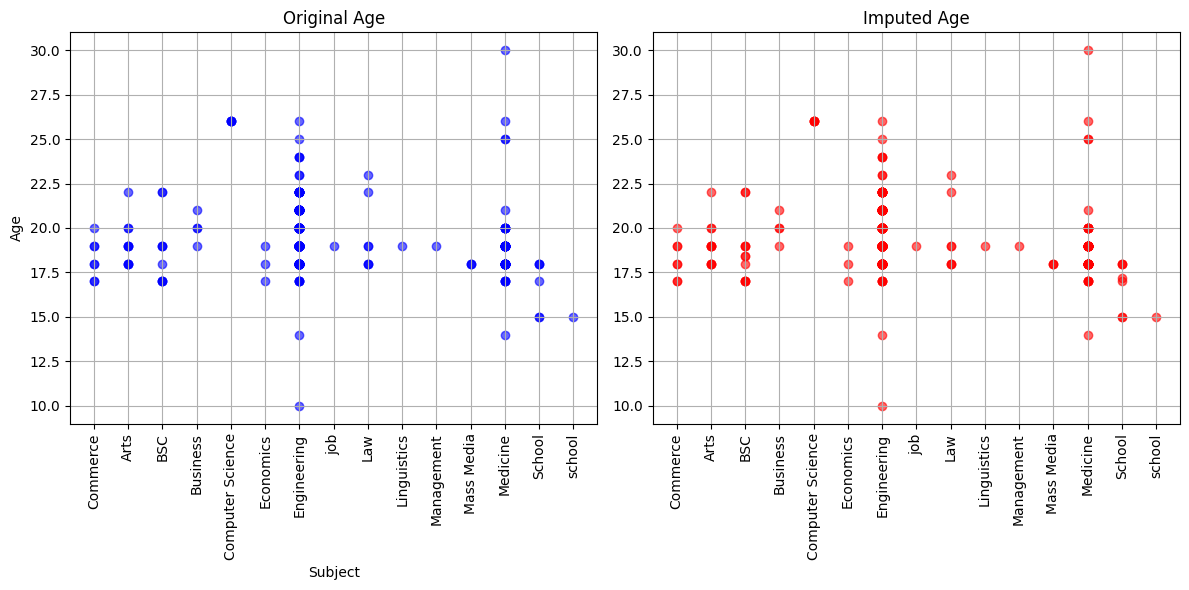

In [66]:
# Load and Clean Data
df = pd.read_excel('raw data.xlsx')
df['Subject'] = df['Subject'].astype(str).str.strip()  # Clean all the white spaces from 'subject' column
df_original = df.copy()  # Backup original
df.drop_duplicates(inplace=True)
df.reset_index(drop=True,inplace=True)
# === Age Imputation with KNN ===
le = LabelEncoder()
df['Subject_encoded'] = le.fit_transform(df['Subject'])
impute_df = df[['Age', 'Subject_encoded']]
imputer = KNNImputer(n_neighbors=5)
imputed = imputer.fit_transform(impute_df)
df['Imputed_Age'] = imputed[:, 0]
# === Plot Original vs Imputed Age ===
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(df['Subject'], df_original['Age'], alpha=0.6, color='blue')
plt.title("Original Age")
plt.xlabel("Subject")
plt.ylabel("Age")
plt.xticks(rotation=90)
plt.grid(True)
plt.subplot(1, 2, 2)
plt.scatter(df['Subject'], df['Imputed_Age'], alpha=0.6, color='red')
plt.title("Imputed Age")
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()
# Feature engineering to create derived scores and encode categories

# Encode categorical
df['Teacher_Support'] = df['Teacher_Support'].map({'Low': 1, 'Medium': 2, 'High': 3}).fillna(2)
df['Peer_Influence'] = df['Peer_Influence'].map({'Negative': 1, 'Neutral': 2, 'Positive': 3}).fillna(2)
df['Class_participation'] = df['Class_participation'].map({'Always': 2, 'Often': 1,'Sometimes': 0, 'Rarely': -1,'Never': -2})
#normalizing a few features
marks_scaler = MinMaxScaler()
df['Marks_Score'] = marks_scaler.fit_transform(df[['Marks']])
df['Attendance_Score'] = df['Attendance'] / df['Attendance'].max()
df['Sleep_Score'] = df['Sleep_Hours'] / df['Sleep_Hours'].max()
df['Health_Score'] = df['Physical_Health'] / df['Physical_Health'].max()
df['Motivation_Score'] = df['Teacher_Support'].map({1: 0.3, 2: 0.6, 3: 1.0})
df['Stress_Score'] = df['Late_submissions'] / df['Late_submissions'].max()
#creating perfromance score
# sleep + health + scaled marks + attendance + teacher support + scaled late submissions
df['Performance_Score'] = (
    df['Sleep_Score'] +
    df['Health_Score'] +
    df['Marks_Score'] +
    df['Attendance_Score'] +
    df['Motivation_Score'] -
    df['Stress_Score']
)
# Prepare for Model Training
features = [
    'Sleep_Hours', 'Physical_Health', 'Study_Resources',
    'Attendance', 'Late_submissions', 'Consistency',
    'Teacher_Support', 'Peer_Influence',
]
X = df[features]
y = df[['Performance_Score']]
#scale features
scaler=StandardScaler()
X_scaled=scaler.fit_transform(X)
Y_scaled=scaler.fit_transform(y).ravel()

# === Added Standard Scaling for clustering (keep original X for ML models) ===
scaler_standard = StandardScaler()
X_standard_scaled = scaler_standard.fit_transform(X)
# Scale target (y) to 0–5
y_scaler = MinMaxScaler(feature_range=(0, 5))
y_scaled = y_scaler.fit_transform(y).ravel()
joblib.dump(y_scaler, 'scaler_y.pkl')
# Scale features
X_scaler = MinMaxScaler()
X_scaled = X_scaler.fit_transform(X)
joblib.dump(X_scaler, 'scaler_X.pkl')
# label students
low_thresh = df['Performance_Score'].quantile(0.33) #below 33 percentile
high_thresh = df['Performance_Score'].quantile(0.66) # below 66 percentile

def check_consistency(row):
    if row['Performance_Score'] <= low_thresh and row['Consistency'] < 2:
        return "Might Underperform. Improve consistency and reduce stress."
    elif row['Performance_Score'] <= high_thresh:
        return "Showing average performance. Maintain motivation and monitor stress."
    else:
        return "Good performance"
df['Performance_Feedback'] = df.apply(check_consistency, axis=1)

# ensuring balanced groups by avoiding hardcoded thresholds
#enables dynamic adaptation to the dataset
def label_performance(score):
    if score <= low_thresh:
        return 0
    elif score <= high_thresh:
        return 1
    else:
        return 2
df['Performance_Label'] = df['Performance_Score'].apply(label_performance)

Exploratory Data Analysis (EDA)

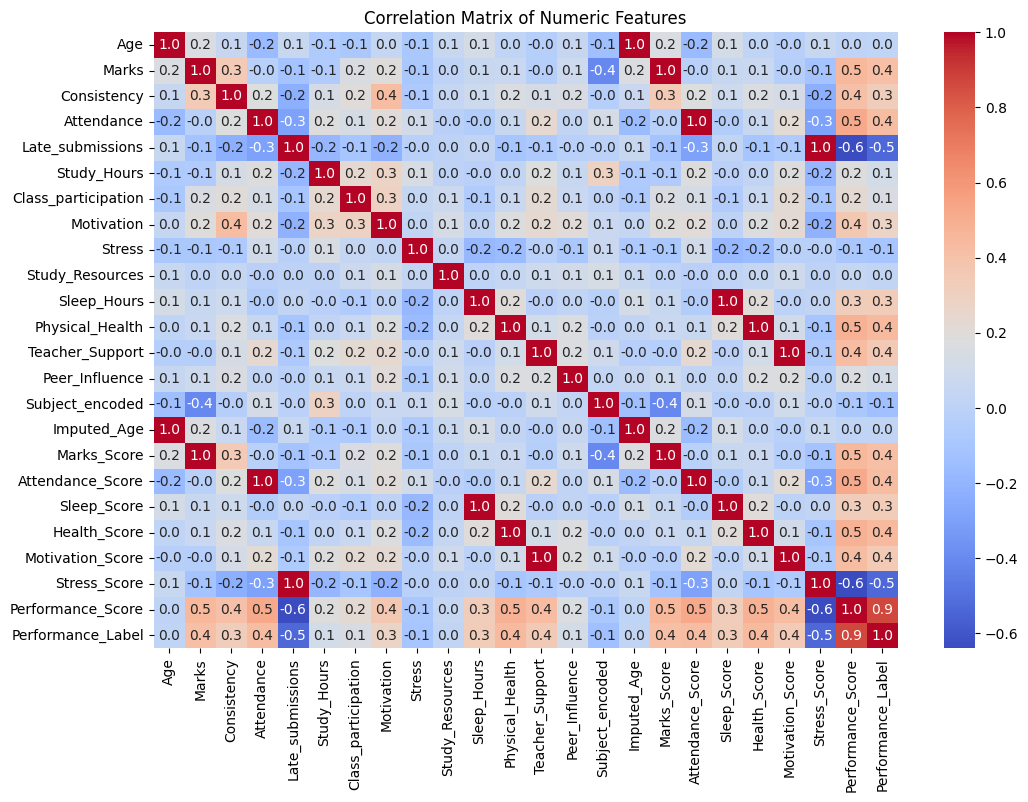

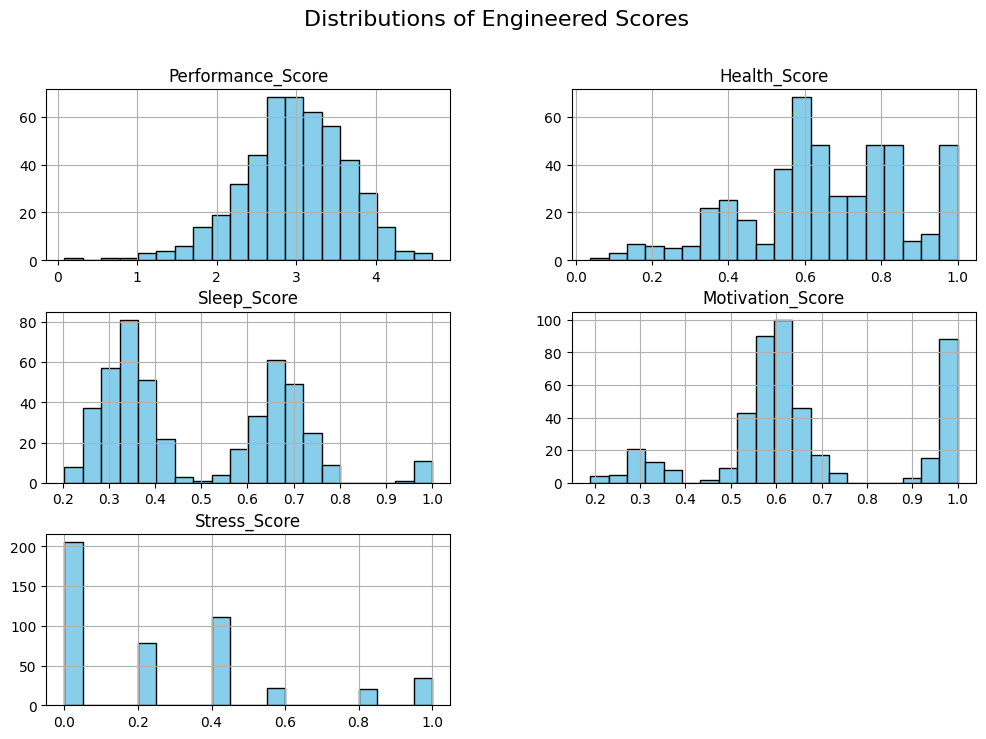

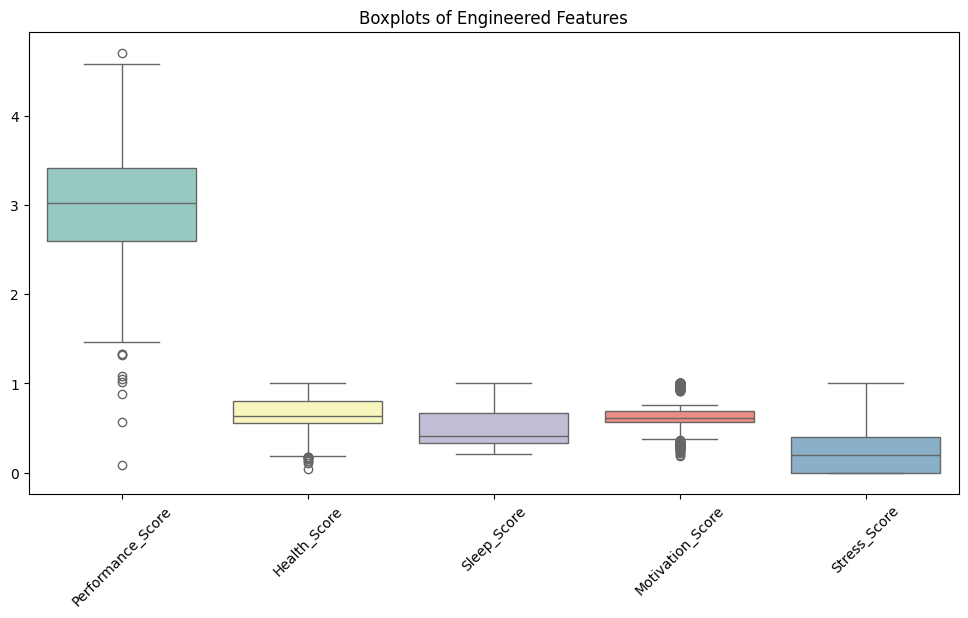

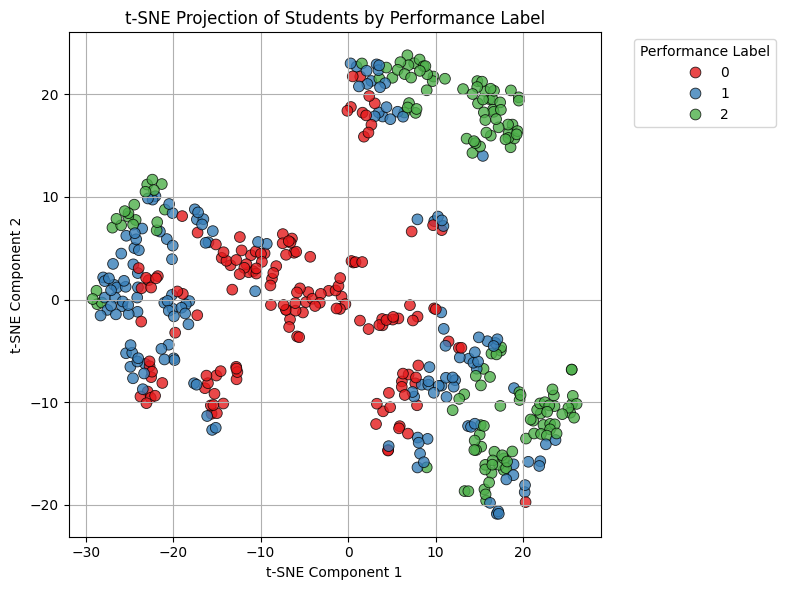

In [67]:
# Correlation matrix heatmap
# Only selecting numeric columns for correlation
plt.figure(figsize=(12, 8))
# Drop unnecessary columns
if 'Unnamed: 22' in df.columns:
    df.drop(columns=['Unnamed: 22'], inplace=True)
numeric_df = df.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".1f", cmap="coolwarm")
plt.title("Correlation Matrix of Numeric Features")
plt.show()

# Add small random noise to make scores more continuous
np.random.seed(42)  # for reproducibility
for col in ['Health_Score', 'Motivation_Score','Sleep_Score']:
    df[col] += np.random.normal(0, 0.05, df.shape[0])
    df[col] = df[col].clip(0, 1)  # keep within [0,1]

# Plot distributions of engineered scores to spot skewness and show how features are spread out
engineered_features = ['Performance_Score', 'Health_Score', 'Sleep_Score', 'Motivation_Score', 'Stress_Score']
df[engineered_features].hist(bins=20, figsize=(12, 8), color='skyblue', edgecolor='black')
plt.suptitle("Distributions of Engineered Scores", fontsize=16)
plt.show()

# Boxplots for detecting outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[engineered_features], palette='Set3')
plt.title("Boxplots of Engineered Features")
plt.xticks(rotation=45)
plt.show()
from sklearn.manifold import TSNE

# t-SNE for 2D projection
features_tsne= [
    'Performance_Score', 'Health_Score', 'Sleep_Score', 'Motivation_Score', 'Stress_Score'
]
X_tsne=df[features_tsne].copy()
#standardize the features
scaler_tsne=StandardScaler()
X_tsne_scaled=scaler_tsne.fit_transform(X_tsne)
tsne = TSNE(n_components=2, random_state=42, perplexity=30,learning_rate=200,n_iter=1000)
X_tsne_2d = tsne.fit_transform(X_tsne_scaled)
# plot t-sne coloured by Performance Label
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x=X_tsne_2d[:, 0], y=X_tsne_2d[:, 1], hue='Performance_Label', palette='Set1',s=60,alpha=0.8,edgecolor='k')
plt.title("t-SNE Projection of Students by Performance Label")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title='Performance Label',bbox_to_anchor=(1.05,1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

Health score, motivation score and sleep score were highly discrete
* health score -> only 5 distinct values
* motivation score -> only 3 distinct values
* sleep score -> only 3 distinct values
this reduces the ability of the model to learn subtle patterns between the variables

Solution:
* added randomness to convert into a continuous representation
* improves model generalisation

Inference from correlation matrix output:
* the engineered scores are behaving as expected.
* the scores and corresponding features that the score is derived from is showing strong positive correlations.
* Stress score and Performance score is showing strong negative correlations.
* Features like peer influence and teacher support have weak correlations since they dont correlate with each other individually.

Inference from histogram:
* Performance score has bell shape which is good for regression
* Health score, motivation score, sleep score and stress score are very discrete or binned because of how they were scaled or collected originally.

Inference from boxplot output:
* Performance score has a few outliers at low values
* Stress score has many zeroes as input showing many students having no stress
* Motivation score has a very sparse distribution

Inference from t-SNE projection:
* it separated students and shows distinct regions for each performance label where some overlap between the three classes :'0', '1', '2'.
* boundaries between the classes are fuzzy so there are overlapping behaviours
* shows why non-linear models like random forest will perform better

Model Building

Linear Regression

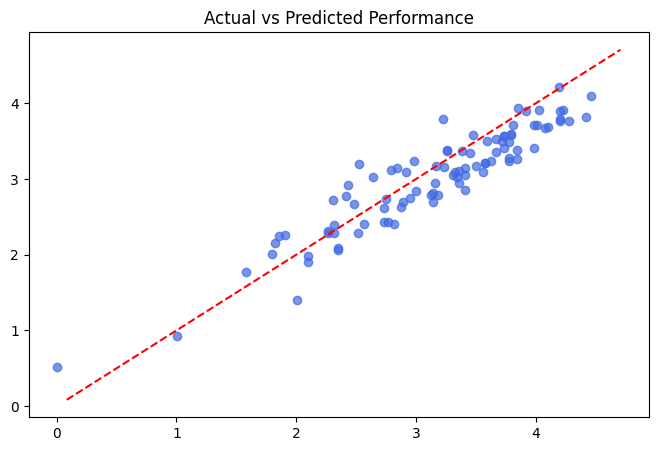

 RMSE value for linear regression: 0.3246
 R² Score for linear regression: 0.8336


In [68]:
# Train the Linear Regression Model
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train_lr, y_train_lr)
joblib.dump(model, 'performance_model.pkl')
# Evaluate Linear Regression
y_pred_scaled = model.predict(X_test_lr)
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
plt.figure(figsize=(8, 5))
plt.scatter(y_test_lr, y_pred, alpha=0.7, color='royalblue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.title('Actual vs Predicted Performance')
plt.show()
print(f" RMSE value for linear regression: {np.sqrt(mean_squared_error(y_test_lr, y_pred)):.4f}")
print(f" R² Score for linear regression: {r2_score(y_test_lr, y_pred):.4f}")


Random forest regressor with GridSearch

 The Best Parameters for Random Forest Regressor are:  {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
 RMSE value: 0.1029 
 R² Score: 0.8101 


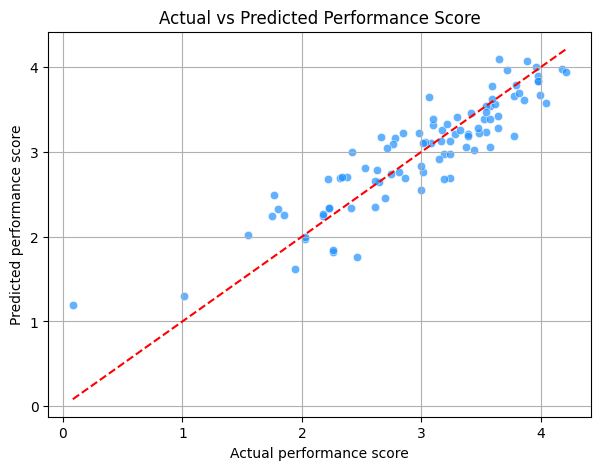

In [69]:
#train-test split
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
param_grid_reg={
    'n_estimators' : [100,200],
    'max_depth':[None,10],
    'min_samples_split':[2,5]
}
regressor=RandomForestRegressor(random_state=42)
grid_reg=GridSearchCV( regressor, param_grid_reg, cv=5, scoring='neg_mean_squared_error',n_jobs=-1)
grid_reg.fit(X_train_reg,y_train_reg)
# evaluate our random forest regressor model
y_pred_reg=grid_reg.predict(X_test_reg).ravel()
rmse_reg=mean_squared_error(y_test_reg,y_pred_reg)
r2_reg=r2_score(y_test_reg,y_pred_reg)
print(" The Best Parameters for Random Forest Regressor are: ", grid_reg.best_params_)
print(f" RMSE value: {rmse_reg:.4f} ")
print(f" R² Score: {r2_reg:.4f} ")

# Save model
joblib.dump(grid_reg.best_estimator_, "performance_model.pkl")

y_test_reg=y_test_reg.values.ravel()
#plot actual vs predicted Performance
plt.figure(figsize=(7,5))
sns.scatterplot(x=y_test_reg,y=y_pred_reg,alpha=0.7, color='dodgerblue')
plt.plot([y_test_reg.min(),y_test_reg.max()], [y_test_reg.min(),y_test_reg.max()],'r--')
plt.title("Actual vs Predicted Performance Score")
plt.xlabel("Actual performance score")
plt.ylabel("Predicted performance score")
plt.grid(True)
plt.show()

Support Vector Regressor

In [70]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
X_train_svr, X_test_svr, y_train_svr, y_test_svr = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
# === Support Vector Regressor (SVR) ===
svr = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
svr.fit(X_train_svr, y_train_svr)

y_pred_svr = svr.predict(X_test_svr)

# Evaluation
rmse_svr = np.sqrt(mean_squared_error(y_test_svr, y_pred_svr))
r2_svr = r2_score(y_test_svr, y_pred_svr)
n = len(y_test_svr)
p = X_test_svr.shape[1]
adj_r2_svr = 1 - (1-r2_svr)*(n-1)/(n-p-1)

print("Support Vector Regressor Results:")
print(f"RMSE: {rmse_svr:.4f}")
print(f"R² Score: {r2_svr:.4f}")
print(f"Adjusted R²: {adj_r2_svr:.4f}")


Support Vector Regressor Results:
RMSE: 0.3175
R² Score: 0.8408
Adjusted R²: 0.8258


Since RMSE of random forest is 3.2 times better than linear regression it is far better in predictive accuracy so Random forest is the preferred model.
a 70 percent reduction in error is far more impactful than a 2 percent drop in r-squared value.

Burnout risk prediction

Best Parameters: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
 Best parameters for classification:  {'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Accuracy: 0.851063829787234

Classification Report:

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.79      0.87        57
           1       0.81      1.00      0.89        29
           2       0.50      0.75      0.60         8

    accuracy                           0.85        94
   macro avg       0.76      0.85      0.79        94
weighted avg       0.88      0.85      0.86        94



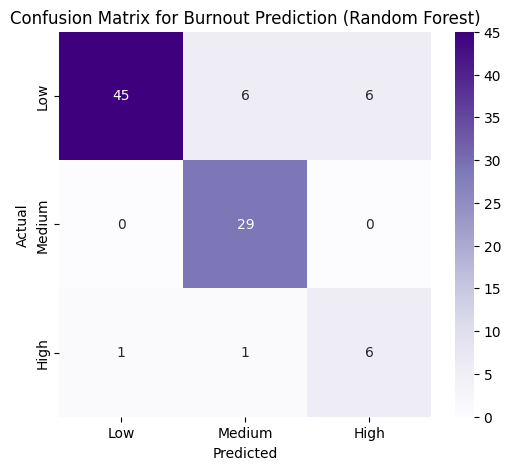

['burnout_model.pkl']

In [71]:
# Burnout label logic
def classify_burnout(stress, motivation):
    if stress >= 4 and motivation <= 2:
        return 'High'
    elif stress >= 3 and motivation <= 3:
        return 'Medium'
    else:
        return 'Low'
df['Burnout_Risk'] = df.apply(lambda row: classify_burnout(row['Stress'], row['Motivation']), axis=1)

# Features and target for burnout classification
burnout_features = [
    'Sleep_Hours', 'Physical_Health', 'Class_participation',
    'Teacher_Support', 'Late_submissions', 'Motivation'
]
X_burnout = df[burnout_features]
y_burnout = df['Burnout_Risk']
y_burnout_encoded=y_burnout.map({'Low':0,'Medium':1,'High':2})
# Train-test split
X_train_clf, X_test_clf, y_train_clf, y_test_clf= train_test_split(
    X_burnout, y_burnout_encoded, test_size=0.2, random_state=42, stratify=y_burnout_encoded
)

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_clf, y_train_clf)

# RandomForestClassifier with class weights and hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced']
}
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)
# Best model
best_rf = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Predictions: Y_PRED_BURNOUT IS FOR RFC
y_pred_burnout = grid_search.predict(X_test_clf)

# Evaluation
print(" Best parameters for classification: ", grid_search.best_params_)
print("Accuracy:", accuracy_score(y_test_clf, y_pred_burnout))
print("\nClassification Report:")
print("\nClassification Report:\n",classification_report(y_test_clf, y_pred_burnout))

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test_clf, y_pred_burnout), annot=True, fmt='d', cmap='Purples',
            xticklabels=['Low', 'Medium', 'High'],
    yticklabels=['Low', 'Medium', 'High']
)
plt.title("Confusion Matrix for Burnout Prediction (Random Forest)")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Save model
joblib.dump(grid_search.best_estimator_, "burnout_model.pkl")


📊 Support Vector Classifier Results:
Accuracy: 0.8511

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.79      0.88        57
           1       0.82      0.93      0.87        29
           2       0.50      1.00      0.67         8

    accuracy                           0.85        94
   macro avg       0.77      0.91      0.81        94
weighted avg       0.90      0.85      0.86        94



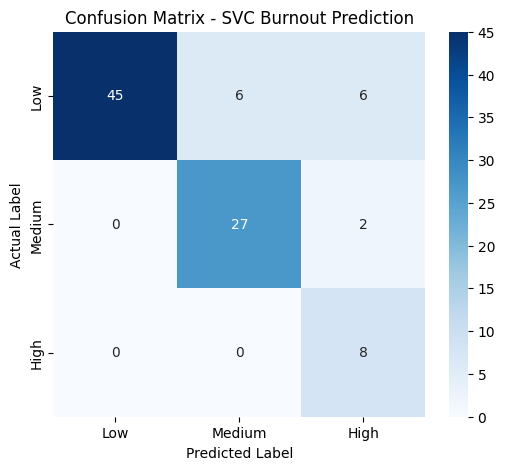

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# === Support Vector Classifier (SVC) ===
# Note: X_train_resampled and y_train_resampled assume you have used SMOTE
# or another technique to balance the data prior to this step.
svc = SVC(kernel='rbf', C=1, gamma='scale', class_weight='balanced', random_state=42)
svc.fit(X_train_resampled, y_train_resampled)

# Correction: Use a NEW, unique prediction variable to avoid overwriting RFC results
y_pred_svc_burnout = svc.predict(X_test_clf)

print("📊 Support Vector Classifier Results:")
print(f"Accuracy: {accuracy_score(y_test_clf, y_pred_svc_burnout):.4f}")
print("\nClassification Report:\n", classification_report(y_test_clf, y_pred_svc_burnout))

# Plot confusion matrix
# IMPORTANT: Labels should be ['Low', 'Medium', 'High'] to match the Burnout_Risk target
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test_clf, y_pred_svc_burnout), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low','Medium','High'], yticklabels=['Low','Medium','High'])
plt.title("Confusion Matrix - SVC Burnout Prediction")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.savefig("confusion_matrix_svc_burnout.png")
# plt.show()


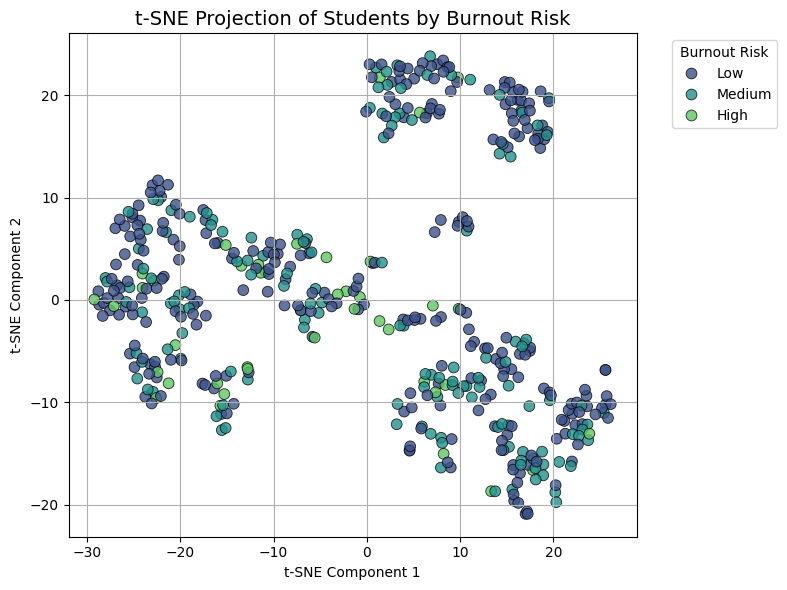

In [73]:
# Plot t-SNE colored by Burnout Risk or Clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df,x=X_tsne_2d[:, 0], y=X_tsne_2d[:, 1], hue='Burnout_Risk', palette='viridis', s=60, alpha=0.8, edgecolor='k')
plt.title('t-SNE Projection of Students by Burnout Risk', fontsize=14)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Burnout Risk', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

Visualizations

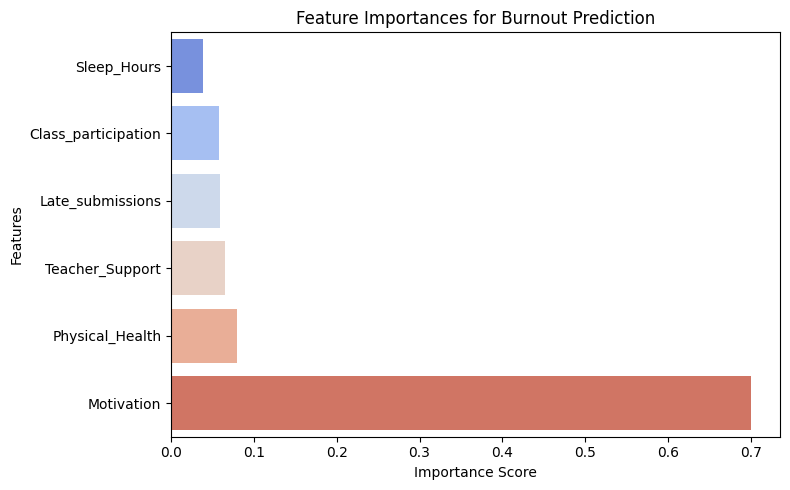

In [74]:
# feature importance for burnout prediction
importances = best_rf.feature_importances_
feat_names = X_burnout.columns
feat_importance_df = pd.DataFrame({'Feature': feat_names, 'Importance': importances})
feat_importance_df.sort_values(by='Importance', ascending=True, inplace=True)
plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=feat_importance_df, palette='coolwarm')
plt.title("Feature Importances for Burnout Prediction")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

SHAP Feature Importance for Performance Regressor


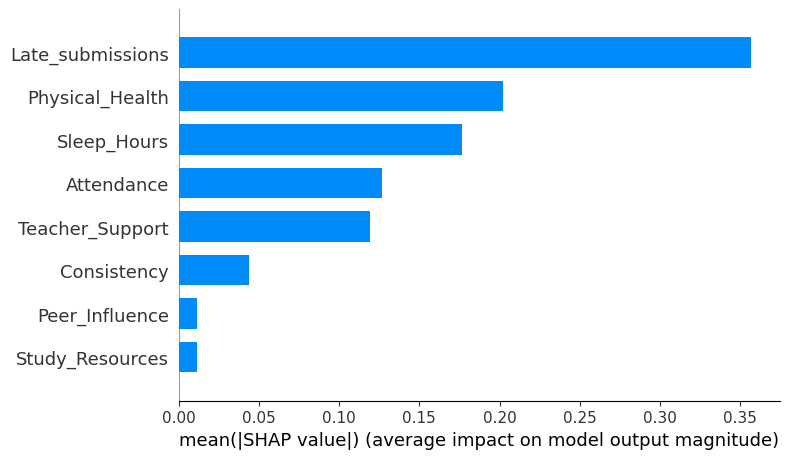

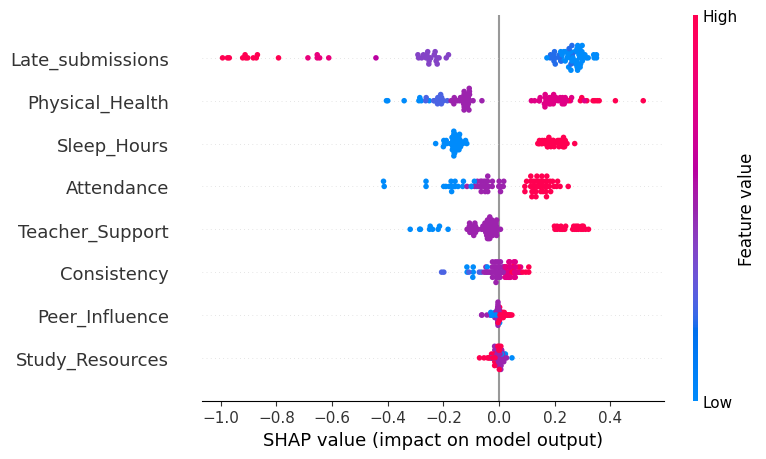

In [75]:
# for regression
# Load the model from the file
rf_model = joblib.load("performance_model.pkl")
# Then use the loaded model
explainer_reg = shap.TreeExplainer(rf_model)
shap_values_reg = explainer_reg.shap_values(X_test_reg)
print("SHAP Feature Importance for Performance Regressor")
shap.summary_plot(shap_values_reg, X_test_reg, plot_type="bar", feature_names=X.columns)
shap.summary_plot(shap_values_reg, X_test_reg, feature_names=X.columns)

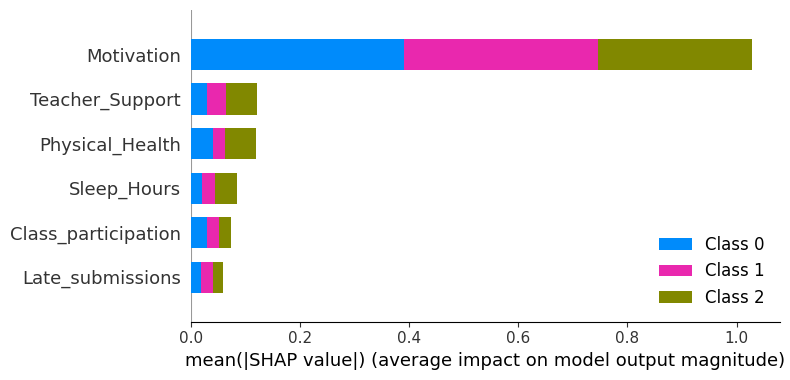

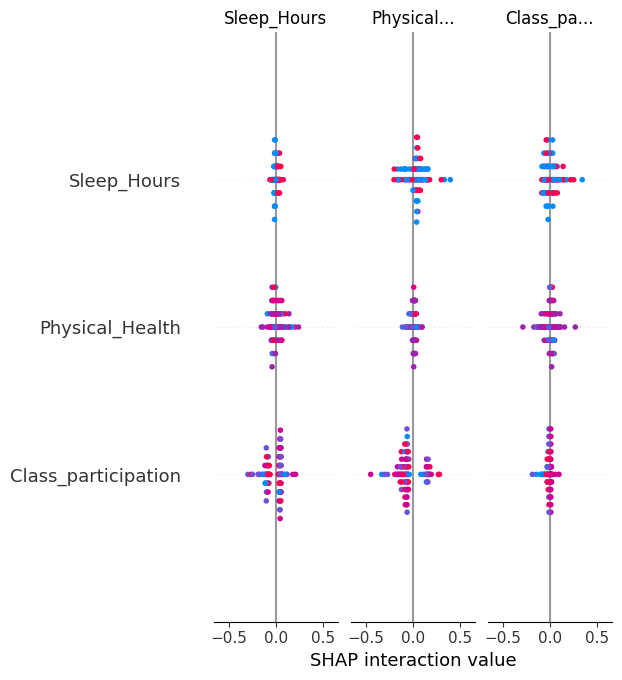

In [76]:
# for classification
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test_clf)
shap.summary_plot(shap_values, X_test_clf, plot_type="bar", feature_names=X_burnout.columns)
shap.summary_plot(shap_values, X_test_clf, feature_names=X_burnout.columns)

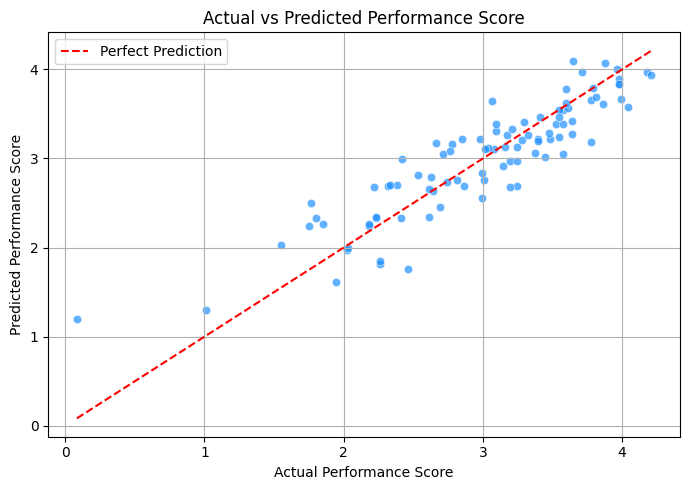

In [77]:
plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_test_reg.ravel(), y=y_pred_reg.ravel(), alpha=0.7, color='dodgerblue')
plt.plot([y_test_reg.min(), y_test_reg.max()],
         [y_test_reg.min(), y_test_reg.max()], 'r--', label='Perfect Prediction')
plt.title("Actual vs Predicted Performance Score")
plt.xlabel("Actual Performance Score")
plt.ylabel("Predicted Performance Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

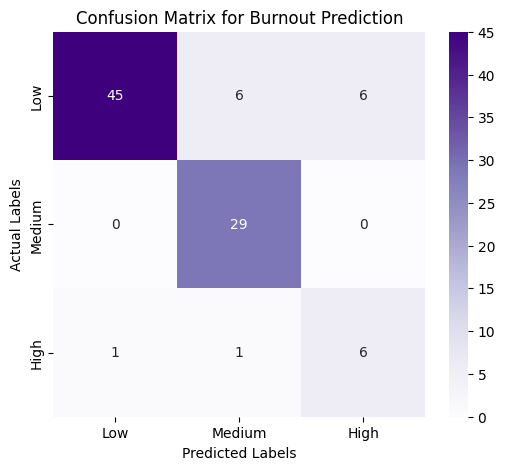

In [78]:
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test_clf, y_pred_burnout)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'])
plt.title("Confusion Matrix for Burnout Prediction")
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.show()


K-means with PCA (no t-SNE)

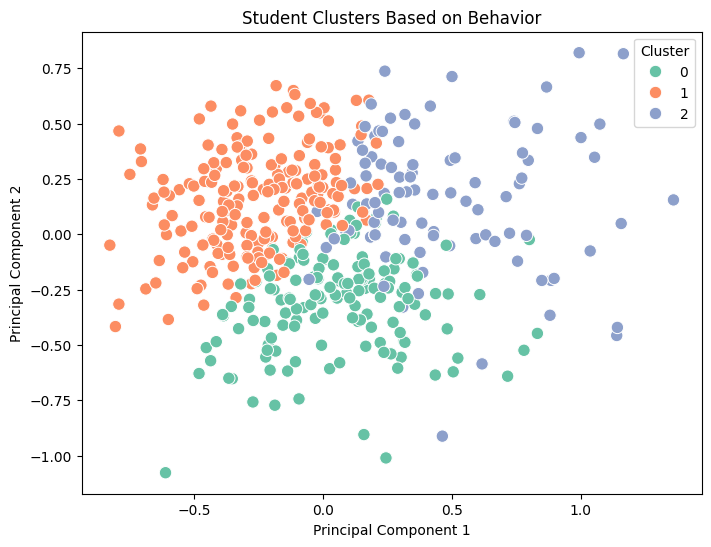

In [79]:
features_cluster = [
    'Motivation', 'Stress', 'Study_Hours',
    'Sleep_Hours', 'Physical_Health', 'Attendance',
    'Late_submissions'
]
X_cluster = df[features_cluster].copy()
#scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_cluster)
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled) #adding a cluster column to dataframe
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='Cluster', palette='Set2', s=80)
plt.title("Student Clusters Based on Behavior")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Cluster')
plt.show()
df.groupby('Cluster')[features_cluster].mean()
label_map = {
    0: 'Motivated but Stressed',
    1: 'Low Motivation, High Risk',
    2: 'Balanced and Stable'
}
df['Cluster_Label'] = df['Cluster'].map(label_map)

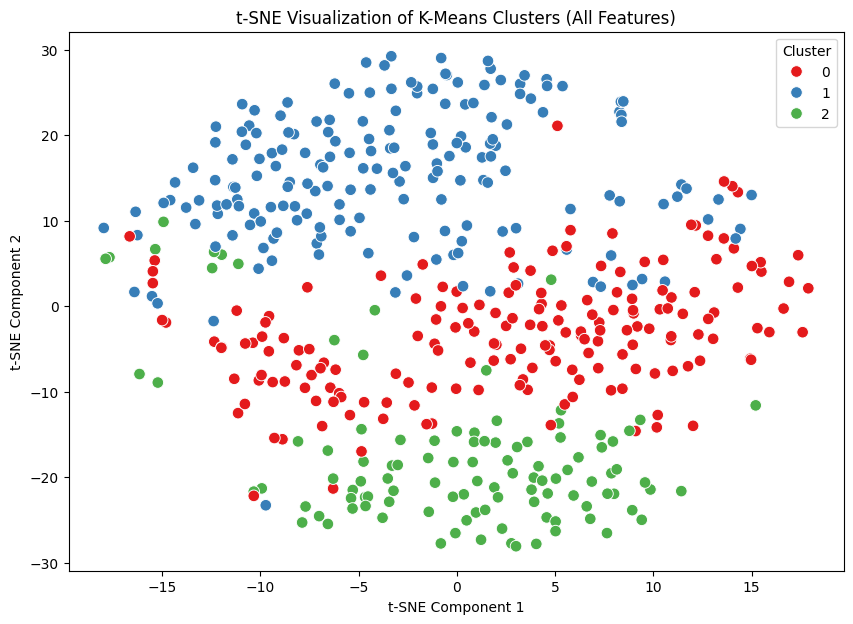

In [80]:
# fix missing values
numeric_features = df.select_dtypes(include=[np.number])
imputer = SimpleImputer(strategy='mean')
imputed_features = imputer.fit_transform(numeric_features)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(imputed_features)
# K-Means clustering
kmeans_all = KMeans(n_clusters=3, random_state=42, n_init=10)
df['KMeans_All_Features'] = kmeans_all.fit_predict(scaled_features)
# t-SNE visualization
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(scaled_features)
df['TSNE1'] = tsne_results[:, 0]
df['TSNE2'] = tsne_results[:, 1]

plt.figure(figsize=(10, 7))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='KMeans_All_Features', palette='Set1', s=70, data=df)
plt.title("t-SNE Visualization of K-Means Clusters (All Features)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title='Cluster')
plt.show()

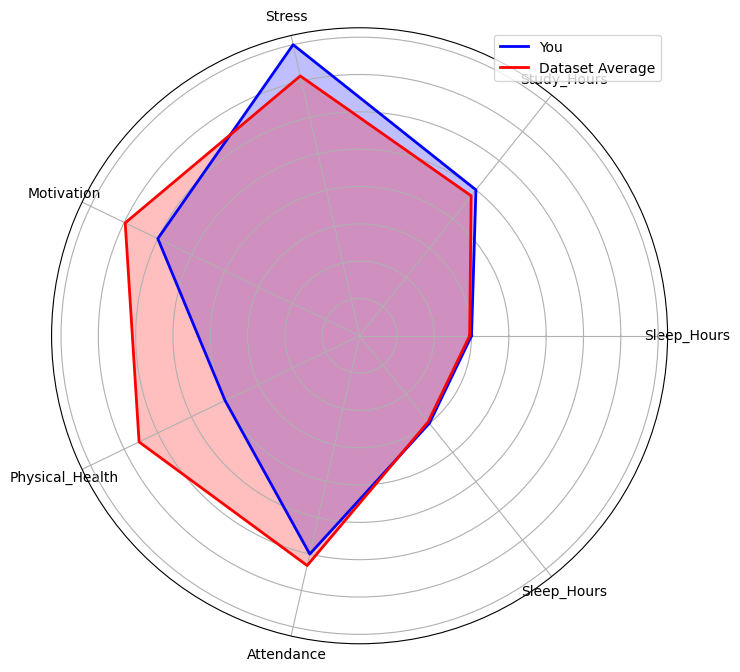

In [81]:
# Dataset average for comparison
dataset_means = {
    "Sleep_Hours": df['Sleep_Hours'].mean(),
    "Study_Hours": df['Study_Hours'].mean(),
    "Stress": df['Stress'].mean(),
    "Motivation": df['Motivation'].mean(),
    "Physical_Health": df['Physical_Health'].mean(),
    "Attendance": df['Attendance'].mean()
}

user_profile = {
    "Sleep_Hours": 1.5,
    "Study_Hours": 2.5,
    "Stress": 4,
    "Motivation": 3,
    "Physical_Health": 2,
    "Attendance": 3,
    "Performance_Score": 12,
    "Burnout_Risk": "Medium",
    "Cluster_Label": "Motivated but Stressed"
}
def plot_spider(user_data, dataset_means, feature_labels):
    # Ensure user and dataset values align with feature_labels
    values = [user_data[feat] for feat in feature_labels]
    avg_values = [dataset_means[feat] for feat in feature_labels]

    # Close the loop for radar plot
    values += values[:1]
    avg_values += avg_values[:1]
    labels = feature_labels + [feature_labels[0]]

    # Close the radar plot
    values += values[:1]
    avg_values += avg_values[:1]
    labels = feature_labels + [feature_labels[0]]

    # Create radar plot
    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    ax.plot(angles, values, color='blue', linewidth=2, label='You')
    ax.fill(angles, values, color='blue', alpha=0.25)

    ax.plot(angles, avg_values, color='red', linewidth=2, label='Dataset Average')
    ax.fill(angles, avg_values, color='red', alpha=0.25)

    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=10)
    plt.legend(loc='upper right')
    plt.show()

# Plot
plot_spider(
    {k: user_profile[k] for k in dataset_means.keys()},
    dataset_means,
    feature_labels=list(dataset_means.keys())
)

Results and Insights

In [82]:
def rule_based_feedback(user_profile):
    # Burnout risk feedback
    if user_profile['Burnout_Risk'] == 'High':
        feedback = "🛑 You are at high burnout risk. Focus on stress reduction and better sleep habits."
    elif user_profile['Burnout_Risk'] == 'Medium':
        feedback = "⚠️ Moderate burnout risk. Maintain healthy habits and motivation strategies."
    else:
        feedback = "🟩 Low burnout risk. Keep up your current routine!"

    # Cluster-specific advice
    if user_profile['Cluster_Label'] == "Motivated but Stressed":
        feedback += " You're highly motivated but need to manage stress levels to avoid burnout."
    elif user_profile['Cluster_Label'] == "Low Motivation, High Risk":
        feedback += " Focus on boosting your motivation and participation in class."
    else:
        feedback += " You have great balance! Set new goals to challenge yourself."

    return feedback

# Generate feedback
feedback = rule_based_feedback(user_profile)
print("Personalized Feedback:\n", feedback)

Personalized Feedback:
 ⚠️ Moderate burnout risk. Maintain healthy habits and motivation strategies. You're highly motivated but need to manage stress levels to avoid burnout.


Test cases

In [ ]:
student_input_low = {
    'Sleep_Hours': 1,
    'Physical_Health': 1,
    'Study_Resources': 1,
    'Attendance': 1,
    'Late_submissions': 5,
    'Consistency': 1,
    'Teacher_Support': 1,
    'Peer_Influence': 1
}
# 2. Average Performer (Moderate habits)
student_input_avg = {
    'Sleep_Hours': 2,
    'Physical_Health': 3,
    'Study_Resources': 2,
    'Attendance': 2,
    'Late_submissions': 2,
    'Consistency': 3,
    'Teacher_Support': 2,
    'Peer_Influence': 2
}
# 3. Good Performer (Best possible values within limits)
student_input_good = {
    'Sleep_Hours': 3,
    'Physical_Health': 5,
    'Study_Resources': 4,
    'Attendance': 4,
    'Late_submissions': 0,
    'Consistency': 5,
    'Teacher_Support': 3,
    'Peer_Influence': 3
}
# 4. Sleep-deprived but consistent
student_input_sleepy = {
    'Sleep_Hours': 1,
    'Physical_Health': 4,
    'Study_Resources': 3,
    'Attendance': 3,
    'Late_submissions': 1,
    'Consistency': 5,
    'Teacher_Support': 2,
    'Peer_Influence': 2
}
# 5. High stress but supported
student_input_stressed = {
    'Sleep_Hours': 2,
    'Physical_Health': 3,
    'Study_Resources': 3,
    'Attendance': 3,
    'Late_submissions': 5,
    'Consistency': 2,
    'Teacher_Support': 3,
    'Peer_Influence': 3 
}
# Run all test cases
all_inputs = {
    "Low Performer": student_input_low,
    "Average Performer": student_input_avg,
    "Good Performer": student_input_good,
    "Sleep-Deprived but Consistent": student_input_sleepy,
    "High Stress but Good Support": student_input_stressed
}

In [84]:
def predict_student_performance(input_data_dict):
    # Load trained components
    model = joblib.load('performance_model.pkl')
    X_scaler = joblib.load('scaler_X.pkl')
    y_scaler = joblib.load('scaler_y.pkl')
    # Convert input to DataFrame
    input_df = pd.DataFrame([input_data_dict])
    input_scaled = X_scaler.transform(input_df)
    # Predict scaled output, then inverse transform
    pred_scaled = model.predict(input_scaled)
    predicted_score = y_scaler.inverse_transform(pred_scaled.reshape(-1, 1)).ravel()[0]
    # Use quantiles from current DataFrame
    low_thresh = df['Performance_Score'].quantile(0.33)
    high_thresh = df['Performance_Score'].quantile(0.66)
    # Label and Feedback
    if predicted_score <= low_thresh:
        label = 0
        feedback = "Might Underperform. Improve consistency and reduce stress."
    elif predicted_score <= high_thresh:
        label = 1
        feedback = "Showing average performance. Maintain motivation and monitor stress."
    else:
        label = 2
        feedback = "Good performance"
    return predicted_score, label, feedback
print("Performance Predictions:\n")
for label_name, input_data in all_inputs.items():
    score, label, feedback = predict_student_performance(input_data)
    print(f" {label_name}")
    print(f" Predicted Score: {score:.2f}\n")

Performance Predictions:

 Low Performer
 Predicted Score: 1.18

 Average Performer
 Predicted Score: 2.53

 Good Performer
 Predicted Score: 4.02

 Sleep-Deprived but Consistent
 Predicted Score: 3.04

 High Stress but Good Support
 Predicted Score: 2.37

